# Objective:  Use data to understand what factors affect the number of bike trips. Make a predictive model to predict the number of trips in a particular hour slot, depending on the environmental conditions.

Problem Statement:

Lyft, Inc. is a transportation network company based in San Francisco, California and operating in 640 cities in the United States and 9 cities in Canada. It develops, markets, and operates the Lyft mobile app, offering car rides, scooters, and a bicycle-sharing system. It is the second largest rideshare company in the world, second to only Uber.

Lyft’s bike-sharing service is also among the largest in the USA. Being able to anticipate demand is extremely important for planning of bicycles, stations, and the personnel required to maintain these. This demand is sensitive to a lot of factors like season, humidity, rain, weekdays, holidays, and more. To enable this planning, Lyft needs to rightly predict the demand according to these factors.

Analysis to be done: 

Rightly predict the bike demand

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
#Load the data file.

data = pd.read_csv('hour.csv')
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [18]:
#Check for null values in the data 

data.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [19]:
#drop records with NAs.
data.dropna(inplace=True)

In [20]:
#Shape
data.shape

(17379, 17)

# Sanity checks

In [72]:
#Duplicate Rows
duplicate = data[data.duplicated()]
duplicate

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt


In [24]:
#Check if registered + casual = cnt for all the records. If not, the row is junk and should be dropped.

np.sum((data.casual+data.registered) != data.cnt)

0

In [75]:
#Write the Code to drop the rows where this is true

data.drop(data[data["registered"]+data["casual"]!=data["cnt"]].index, inplace= True)

In [26]:
#Month values should be 1-12 only
np.unique(data.mnth)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [27]:
#Hour values should be 0-23
np.unique(data.hr)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

In [22]:
#The variables ‘casual’ and ‘registered’ are redundant and need to be dropped. 
#Instant’ is the index and needs to be dropped too. 
#The date column dteday will not be used in the model building, and therefore needs to be dropped.
#Create a new dataframe named inp1.

col_drop = ['casual','registered','instant','dteday']

inp1 = data.drop(col_drop, axis = 1).copy()
inp1.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


# Univariate Analysis

In [23]:
#Describe the numerical fields in the dataset using pandas describe method.
inp1.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,189.463088
std,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,181.387599
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,40.000000
50%,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,142.000000
75%,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,281.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


<AxesSubplot:ylabel='Density'>

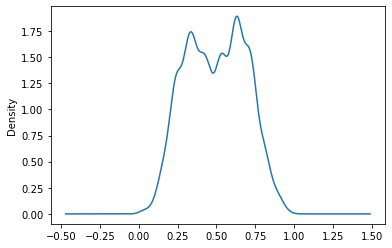

In [24]:
#Make density plot for temp. This would give a sense of the centrality and the spread of the distribution.
inp1.temp.plot.density()

<AxesSubplot:xlabel='temp', ylabel='Density'>

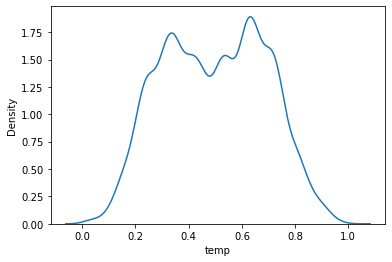

In [76]:
#Denisty Plot By Seaborn

sns.kdeplot(data['temp'])

C:\Users\Acer\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='atemp'>

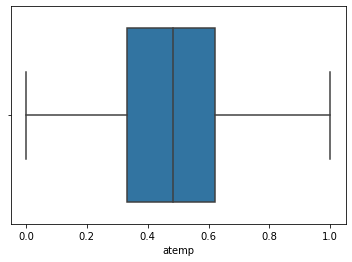

In [26]:
#Boxplot for atemp 
sns.boxplot(inp1.atemp)

<AxesSubplot:ylabel='Frequency'>

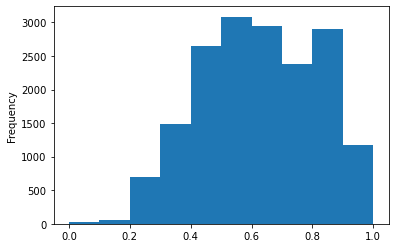

In [27]:
#Histogram for hum
inp1.hum.plot.hist()

<AxesSubplot:xlabel='hum', ylabel='Count'>

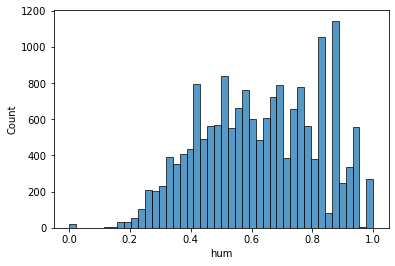

In [28]:
#Histogram for hum
sns.histplot(data = inp1.hum)

<AxesSubplot:ylabel='Density'>

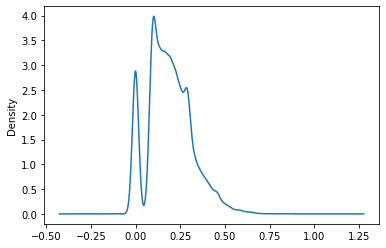

In [29]:
#Density plot for windspeed
inp1.windspeed.plot.density()

<AxesSubplot:ylabel='Density'>

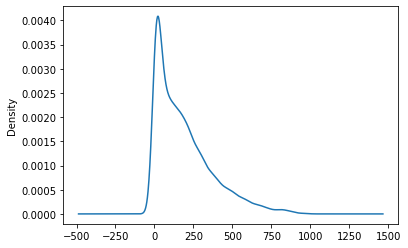

In [30]:
#density plot for cnt – this is the variable of interest 
inp1.cnt.plot.density()

C:\Users\Acer\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cnt'>

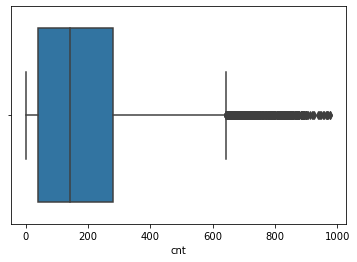

In [31]:
#Box plot for cnt – this is the variable of interest 
sns.boxplot(inp1.cnt)

#  Outlier treatment:  

Cnt looks like some hours have rather high values. You’ll need to treat these outliers so that they don’t skew the analysis and the model. 

In [32]:
#the following percentiles: 10, 25, 50, 75, 90, 95, 99
inp1.cnt.quantile([0.1, 0.25, 0.5, 0.70, 0.9, 0.95, 0.99])

0.10      9.00
0.25     40.00
0.50    142.00
0.70    244.00
0.90    451.20
0.95    563.10
0.99    782.22
Name: cnt, dtype: float64

In [33]:
#the cutoff percentile and drop records with values higher than the cutoff. Name the new dataframe as inp2.
#563 is the 95th percentile – only 5% records have a value higher than this. Taking this as the cutoff.

inp2 = inp1[inp1.cnt < 563].copy()


C:\Users\Acer\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cnt'>

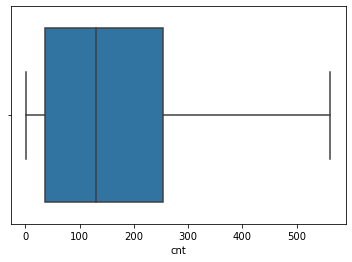

In [44]:
sns.boxplot(inp2.cnt)

# Bivariate Analysis

C:\Users\Acer\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='hr', ylabel='cnt'>

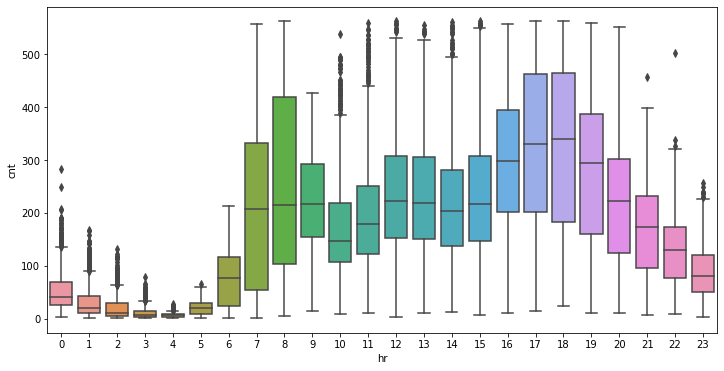

In [34]:
#Make boxplot for cnt vs. hour
plt.figure(figsize=[12,6])
sns.boxplot("hr", "cnt", data=inp2)


C:\Users\Acer\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='weekday', ylabel='cnt'>

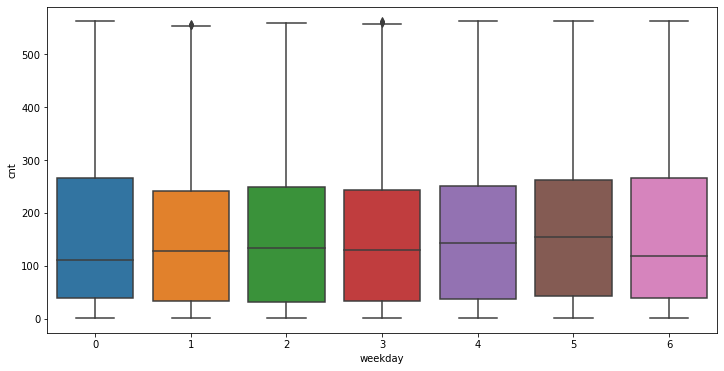

In [37]:
#Make boxplot for cnt vs. weekday
plt.figure(figsize=[12,6])
sns.boxplot("weekday", "cnt", data=inp2)

C:\Users\Acer\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mnth', ylabel='cnt'>

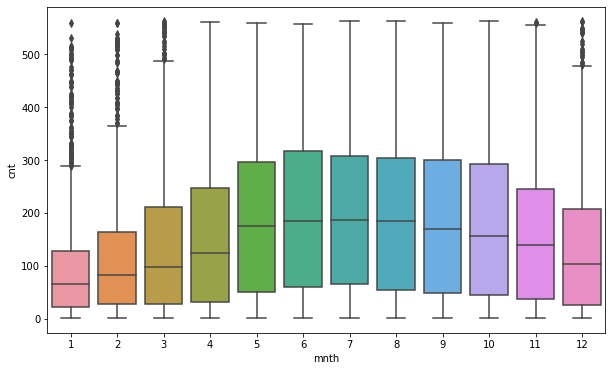

In [35]:
#Make boxplot for cnt vs. month

plt.figure(figsize=[10,6])

sns.boxplot("mnth", "cnt", data=inp2)

C:\Users\Acer\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='season', ylabel='cnt'>

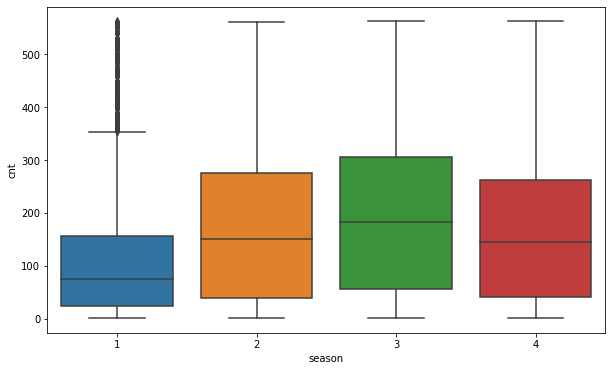

In [38]:
#Make boxplot for cnt vs. season
plt.figure(figsize=[10,6])
sns.boxplot("season", "cnt", data=inp2)

<AxesSubplot:xlabel='hr', ylabel='cnt'>

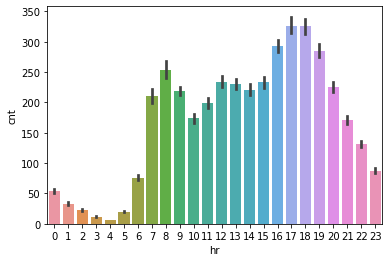

In [88]:
#Make a bar plot with the median value of cnt for each hr
#Bar Plot Stick tell about the error

sns.barplot(x='hr', y='cnt', data =inp2)

In [39]:
#Make a correlation matrix for variables atemp, temp, hum, and windspeed
num_vars = ['temp', 'atemp', 'hum', 'windspeed']
corrs = inp2[num_vars].corr()
corrs

,temp,atemp,hum,windspeed
temp,1.000000,0.988218,-0.042603,-0.033209
atemp,0.988218,1.000000,-0.025747,-0.073985
hum,-0.042603,-0.025747,1.000000,-0.288648
windspeed,-0.033209,-0.073985,-0.288648,1.000000


<AxesSubplot:>

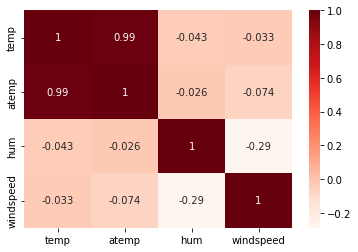

In [40]:
sns.heatmap(corrs, annot=True, cmap="Reds")

# Data preprocessing

A few key considerations for the preprocessing: 

There are plenty of categorical features. Since these categorical features can’t be used in the predictive model, you need to convert to a suitable numerical representation. Instead of creating dozens of new dummy variables, try to club levels of categorical features wherever possible. For a feature with high number of categorical levels, you can club the values that are very similar in value for the target variable. 

1. Treating mnth column

For values 5,6,7,8,9,10, replace with a single value 5. This is because these have very similar values for cnt.

In [116]:
inp3 = inp2.copy()

In [117]:
#Replace Function

inp3.mnth[inp3.mnth.isin([5,6,7,8,9])] = 5

C:\Users\Acer\AppData\Local\Temp/ipykernel_9140/3654173097.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp3.mnth[inp3.mnth.isin([5,6,7,8,9])] = 5


In [118]:
np.unique(inp3.mnth)

array([ 1,  2,  3,  4,  5, 10, 11, 12], dtype=int64)

Treating hr column

Create new mapping: 0-5: 0, 11-15: 11; other values are untouched. Again, the bucketing is done in a way that hr values with similar levels of cnt are treated the same.

In [119]:
inp3.hr[inp3.hr.isin([0,1,2,3,4])] = 0
inp3.hr[inp3.hr.isin([11,12,13,14,15])] = 11

C:\Users\Acer\AppData\Local\Temp/ipykernel_9140/443845199.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp3.hr[inp3.hr.isin([0,1,2,3,4])] = 0
C:\Users\Acer\AppData\Local\Temp/ipykernel_9140/443845199.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inp3.hr[inp3.hr.isin([11,12,13,14,15])] = 11


In [120]:
np.unique(inp3.hr)

array([ 0,  5,  6,  7,  8,  9, 10, 11, 16, 17, 18, 19, 20, 21, 22, 23],
      dtype=int64)

#Get dummy columns for season, weathersit, weekday, mnth, and hr.

In [121]:
list = ['season', 'weathersit', 'weekday', 'mnth','hr']

In [123]:
inp3 = pd.get_dummies(inp3, columns=list)

In [124]:
inp3.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_1,season_2,...,hr_10,hr_11,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23
0,0,0,0,0.24,0.2879,0.81,0.0,16,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0.22,0.2727,0.80,0.0,40,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0.22,0.2727,0.80,0.0,32,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0.24,0.2879,0.75,0.0,13,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0.24,0.2879,0.75,0.0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


# Train test split: Apply 70-30 split.

- call the new dataframes df_train and df_test


In [154]:
from sklearn.model_selection import train_test_split
df_train, df_test =  train_test_split(inp3, test_size=0.30, random_state=32)

In [155]:
df_train.shape

(11551, 47)

In [156]:
df_test.shape

(4951, 47)

 Separate X and Y for df_train and df_test. For example, you should have X_train, y_train from df_train. y_train should be the cnt column from inp3 and X_train should be all other columns.

In [157]:
y_train = df_train.pop("cnt") #Poped cnt stored in y_train
X_train = df_train

In [158]:
y_test = df_test.pop("cnt")
X_test = df_test

In [159]:
X_train

,yr,holiday,workingday,temp,atemp,hum,windspeed,season_1,season_2,season_3,...,hr_10,hr_11,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23
1473,0,0,0,0.34,0.3030,1.00,0.2985,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1294,0,0,0,0.26,0.2727,0.87,0.1343,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4830,0,0,1,0.72,0.7121,0.84,0.0896,0,0,1,...,0,0,0,0,0,0,0,0,0,0
15595,1,0,1,0.38,0.3939,0.76,0.0000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15005,1,0,0,0.66,0.6212,0.65,0.3284,0,0,1,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13774,1,0,1,0.66,0.6061,0.83,0.0000,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6815,0,0,0,0.60,0.6212,0.35,0.2985,0,0,0,...,0,1,0,0,0,0,0,0,0,0
9601,1,0,1,0.28,0.3030,0.65,0.0896,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9846,1,1,0,0.24,0.1970,0.52,0.4179,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [160]:
y_train

1473      25
1294      22
4830       6
15595     49
15005    474
        ... 
13774      6
6815     438
9601      43
9846      10
11140    265
Name: cnt, Length: 11551, dtype: int64

In [161]:
X_test

,yr,holiday,workingday,temp,atemp,hum,windspeed,season_1,season_2,season_3,...,hr_10,hr_11,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23
5433,0,0,1,0.66,0.6061,0.83,0.0896,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8516,0,1,0,0.38,0.3939,0.40,0.3284,1,0,0,...,0,1,0,0,0,0,0,0,0,0
328,0,0,0,0.16,0.2273,0.59,0.0000,1,0,0,...,0,0,0,0,0,0,0,0,0,0
15457,1,0,1,0.36,0.3485,0.50,0.1642,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9931,1,0,1,0.46,0.4545,0.44,0.1343,1,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15351,1,0,0,0.48,0.4697,0.55,0.2537,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2190,0,0,1,0.26,0.2727,0.60,0.1343,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7581,0,0,1,0.34,0.3030,0.53,0.2985,0,0,0,...,0,1,0,0,0,0,0,0,0,0
8963,1,0,0,0.12,0.1515,0.54,0.1045,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [162]:
y_test

5433     263
8516     153
328        5
15457    159
9931     269
        ... 
15351    247
2190       4
7581     121
8963      92
9096      90
Name: cnt, Length: 4951, dtype: int64

# Model building

Use linear regression as the technique

In [163]:
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()

In [164]:
#Fit() training

linear_reg.fit(X_train, y_train)

LinearRegression()

In [166]:
y_pred = linear_reg.predict(X_test)
y_pred

array([222.625, 137.   , -71.375, ..., 170.375, 225.75 ,  84.5  ])

Report the R2 on the train set

In [170]:
#Calculate r2 score
from sklearn.metrics import r2_score

print(r2_score(y_pred,y_test))

0.5008547392786801


In [172]:
#Cross validation

from sklearn.metrics import r2_score

print(r2_score(linear_reg.predict(X_train),y_train))

0.5089474053254828


In [173]:
#Overfitting - Training accuracy is more but test accuracy is less